In [1]:
#Fine-tuning Way

# Feature Extaction#######
#representations learned by a previous network to extract interesting features 
#from new samples. This is then run through a new classifier
#Old conv base + New Classifier
# Key concept: Since representations of the 1st few layers are local, non-generic features
# so we don't use the first few layers or the top and use higher generic layers only

#In feature extraction: conv base was frozen while dense layers were trainable. 
#While in fine tuning, some part of conv base is unfrozen. This unfrozen conv base + dense layers are trained together


from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, #this is the classifer that we dont use; also image net classifier has 1000 categories whereas we only have 1
                  input_shape=(150, 150, 3)) #optional; it can process any size
#Conv base looks like the following
conv_base.summary()

Using TensorFlow backend.








_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
____

In [2]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [9]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
Total params: 14,714,688
Trainable params: 7,079,424
Non-trainable params: 7,635,264
_________________________________________________________________


In [7]:
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/oj/Downloads/project/images'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 160 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


In [9]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=20)

Epoch 1/30


ValueError: Error when checking target: expected flatten_1 to have shape (8192,) but got array with shape (1,)

In [6]:
#model.save('opus_fine_tuning_pretrained_conv.h5')
model.save_weights('weights_opus_fine_tuning_pretrained_conv.h5')

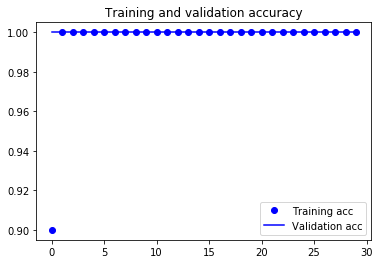

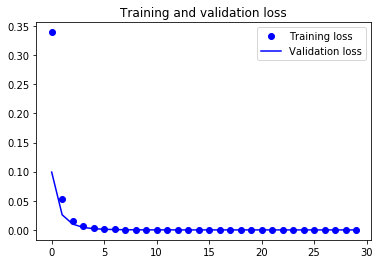

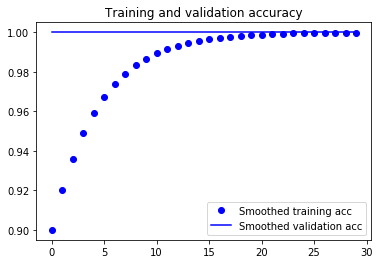

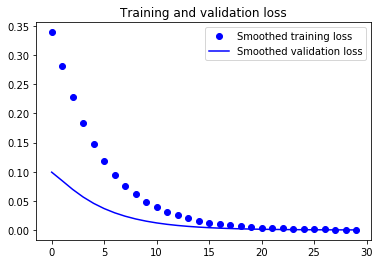

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#making above graphs smoother. This is done by replacing every loss and accuracy with exponential moving averages
#This is for readability

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Found 20 images belonging to 1 classes.
test acc: 1.0
Found 160 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


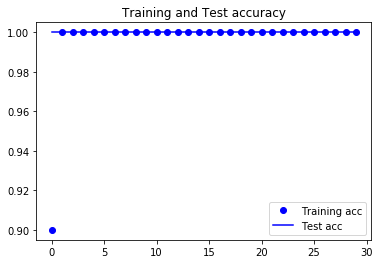

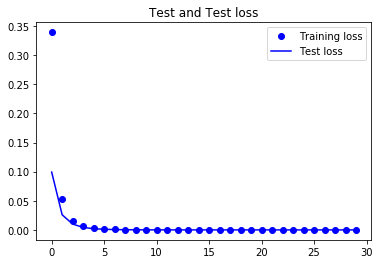

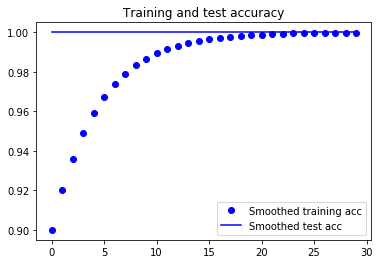

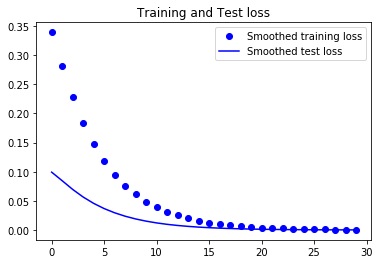

In [9]:
#finally on test data
import matplotlib.pyplot as plt

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

#####################################
####My own test acc printing#####

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

test2_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')



acc = history.history['acc']
test2_acc = history.history['val_acc'] #test_acc is in model.evaluate but you can plot it using the val_Acc and pointing it to the test_dir
loss = history.history['loss']
test2_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Test and Test loss')
plt.legend()

plt.show()


def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(test2_acc), 'b', label='Smoothed test acc')
plt.title('Training and test accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(test2_loss), 'b', label='Smoothed test loss')
plt.title('Training and Test loss')
plt.legend()

plt.show()